<a href="https://colab.research.google.com/github/jibbsmathew/BritishAirways_DataScienceTask2/blob/main/BritishAirwaysTask2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os, sys, itertools, re

if 'google.colab' in sys.modules:
    project_path =  "/content/drive/My Drive/"
    # Google Colab lib
    from google.colab import drive
    # Mount the drive
    drive.mount('/content/drive/', force_remount=True)
    sys.path.append(project_path)
    %cd $project_path

Mounted at /content/drive/
/content/drive/My Drive


In [ ]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [ ]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [ ]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [ ]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [ ]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


Data Visualization:
Create visualizations to understand the distribution of numeric and categorical variables.

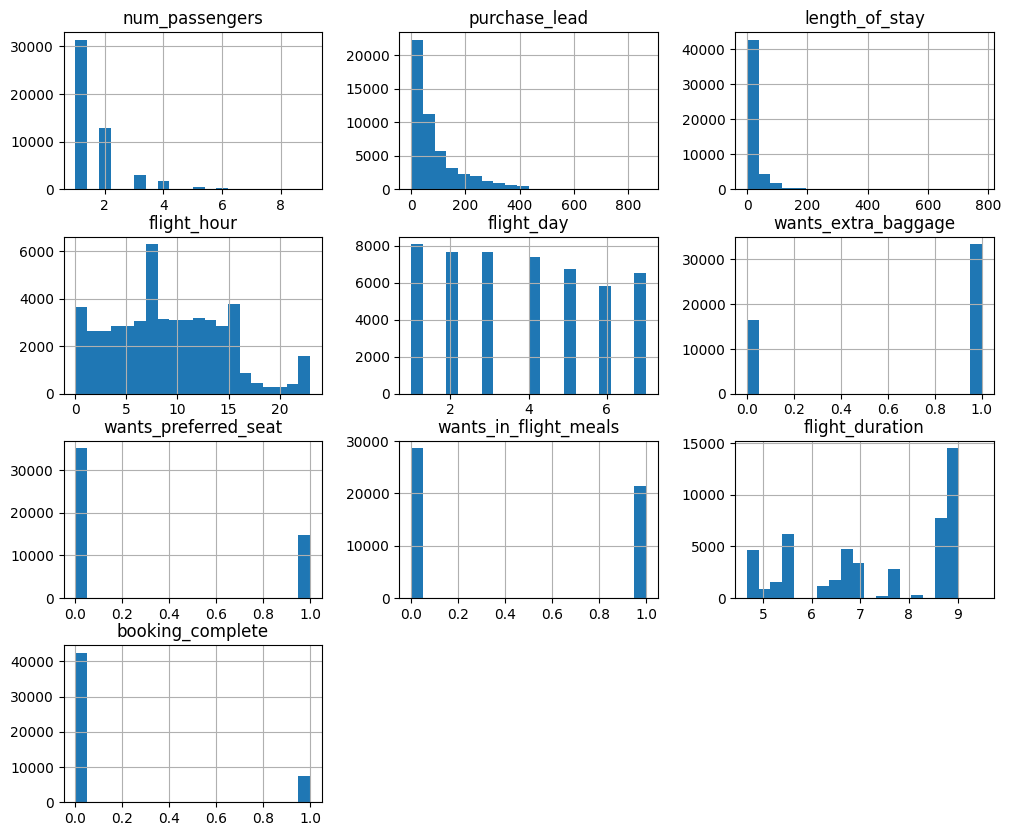

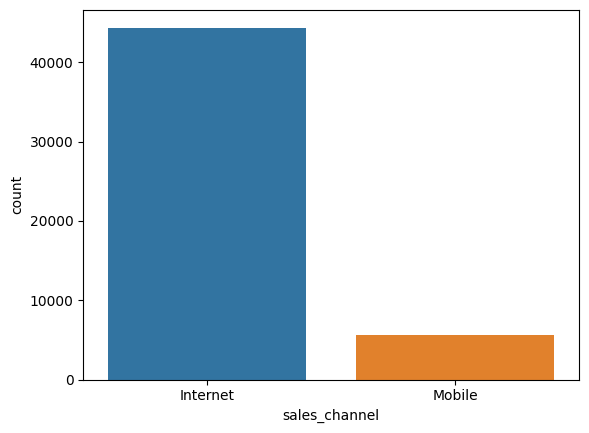

In [ ]:
# Example: Histogram for numeric columns
df.hist(figsize=(12, 10), bins=20)
plt.show()

# Example: Countplot for categorical columns
sns.countplot(x='sales_channel', data=df)
plt.show()

Correlation Analysis:
Examine correlations between numeric variables.

<ipython-input-10-baba55100c02>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


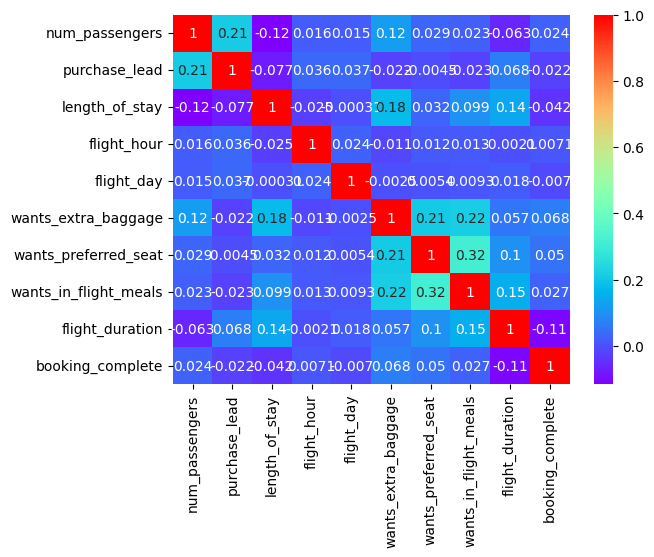

In [ ]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='rainbow')
plt.show()

Feature Relationships:
Explore relationships between features.

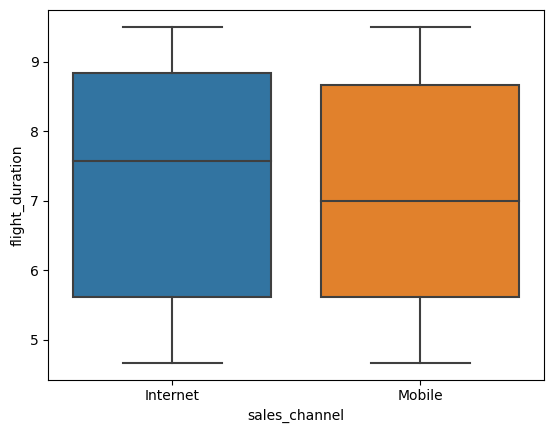

In [ ]:
# Example: Boxplot to visualize relationship between 'sales_channel' and 'flight_duration'
sns.boxplot(x='sales_channel', y='flight_duration', data=df)
plt.show()

Feature Engineering:
Create new features if needed, and transform existing ones.

In [ ]:
# Example: Creating a new feature 'trip_duration' from 'flight_duration' and 'length_of_stay'
df['trip_duration'] = df['flight_duration'] * df['length_of_stay']

Statistical Tests (if applicable):
Conduct statistical tests to validate hypotheses.

In [ ]:
# Example: T-test between two groups
from scipy.stats import ttest_ind
group1 = df[df['sales_channel'] == 'Online']['flight_duration']
group2 = df[df['sales_channel'] == 'Offline']['flight_duration']
t_stat, p_value = ttest_ind(group1, group2)
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: nan, P-value: nan


   num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0                     0        

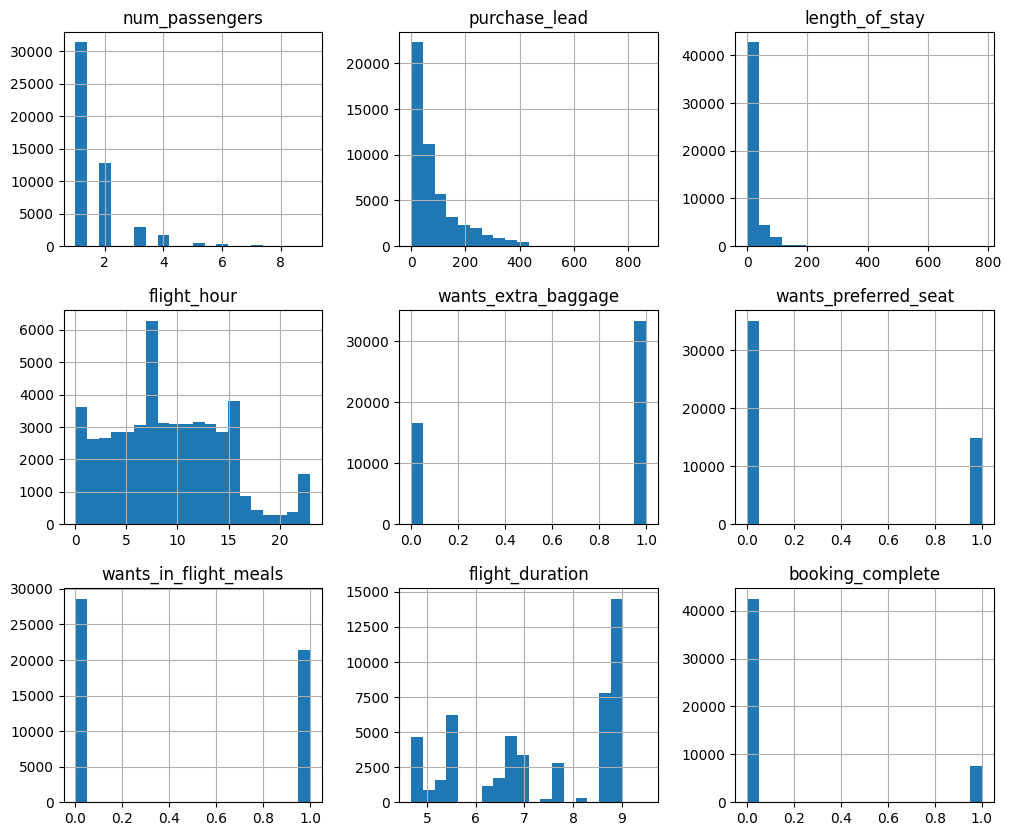

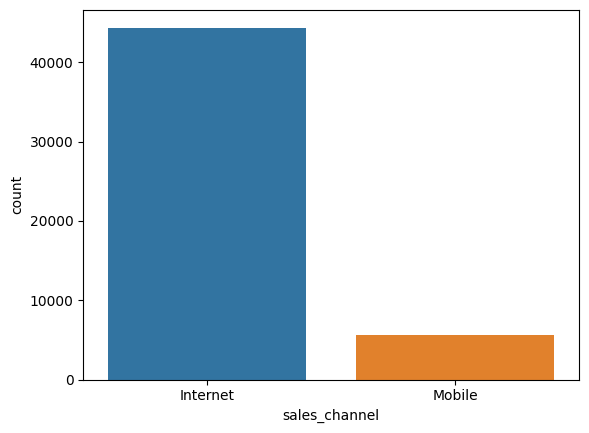

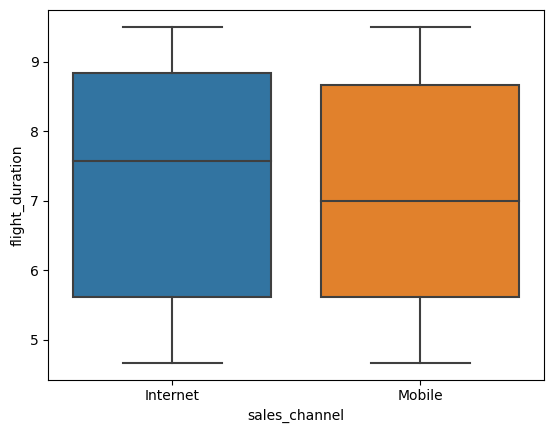

<ipython-input-14-01c20be5e7c3>:31: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


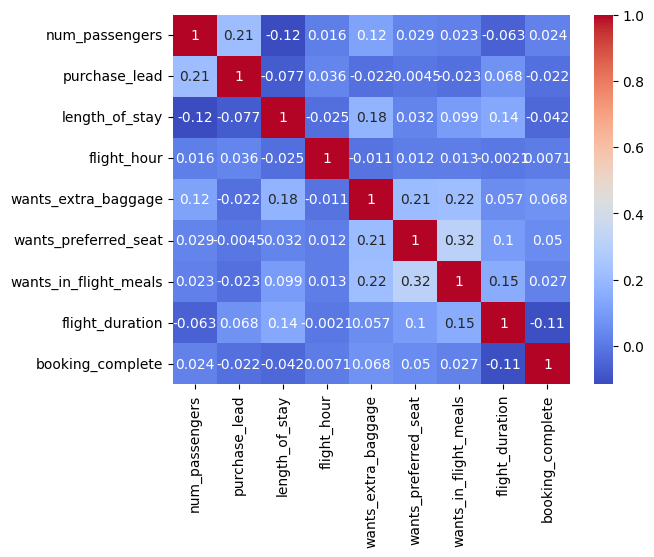

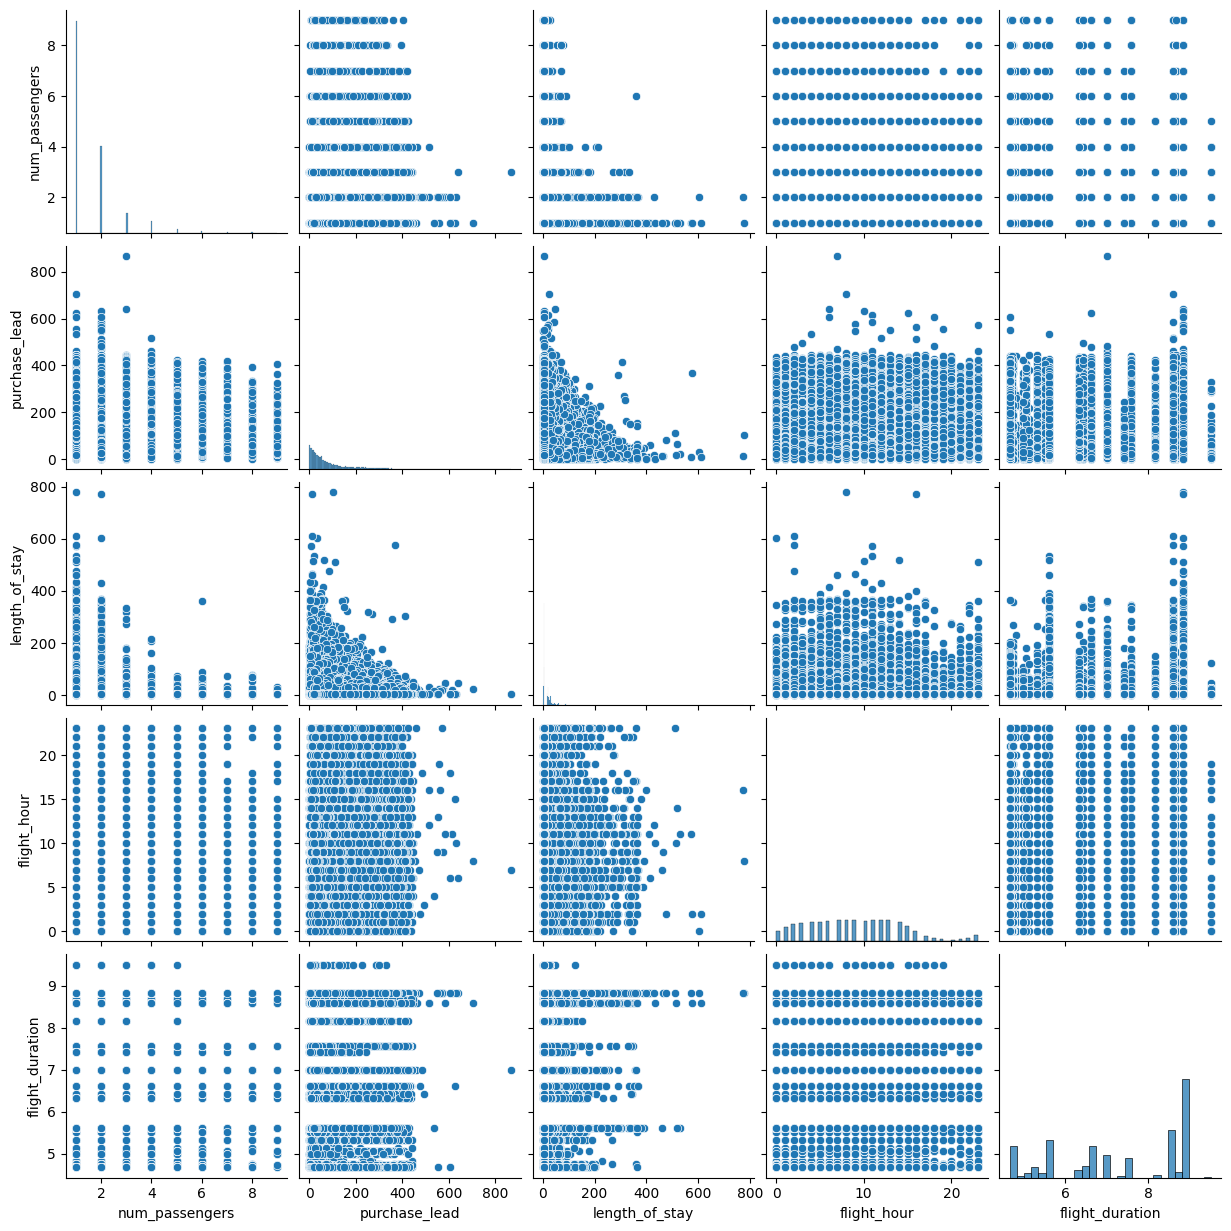

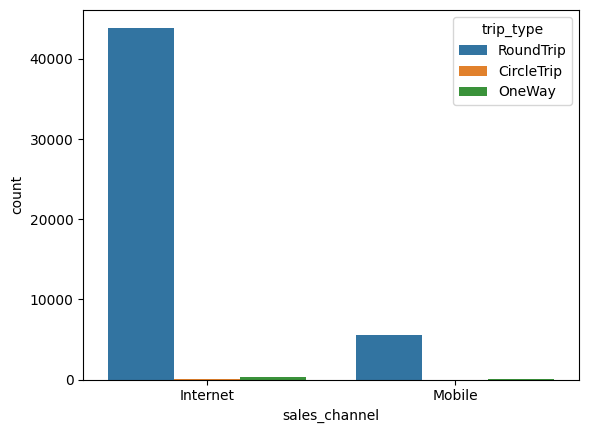

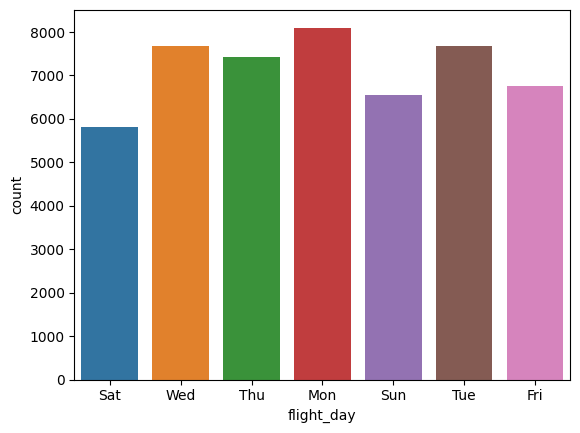

T-statistic: 126.74585141824619, P-value: 0.0


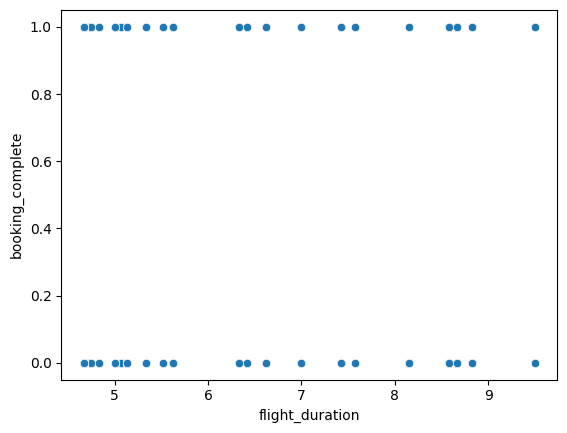

In [ ]:
from scipy.stats import ttest_ind

# Load your dataset
df = pd.read_csv('data/customer_booking.csv',encoding="ISO-8859-1")  # Replace 'your_dataset.csv' with your actual file name

# Display the first few rows of the dataset
print(df.head())

# Summary statistics for numeric columns
print(df.describe())

# Data types and missing values
print(df.info())
print(df.isnull().sum())

# Data Visualization

# Histogram for numeric columns
df.hist(figsize=(12, 10), bins=20)
plt.show()

# Countplot for categorical columns
sns.countplot(x='sales_channel', data=df)
plt.show()

# Boxplot to visualize relationship between 'sales_channel' and 'flight_duration'
sns.boxplot(x='sales_channel', y='flight_duration', data=df)
plt.show()

# Correlation matrix
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Additional Analysis

# Pairplot for selected numeric columns
sns.pairplot(df[['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']])
plt.show()

# Compare 'sales_channel' and 'trip_type'
sns.countplot(x='sales_channel', hue='trip_type', data=df)
plt.show()

# Explore the distribution of 'flight_day'
sns.countplot(x='flight_day', data=df)
plt.show()

# T-test between 'wants_extra_baggage' and 'wants_preferred_seat'
t_stat, p_value = ttest_ind(df['wants_extra_baggage'], df['wants_preferred_seat'])
print(f'T-statistic: {t_stat}, P-value: {p_value}')

# Explore the relationship between 'flight_duration' and 'booking_complete'
sns.scatterplot(x='flight_duration', y='booking_complete', data=df)
plt.show()

Test set accuracy: 0.8541
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      8520
           1       0.53      0.13      0.21      1480

    accuracy                           0.85     10000
   macro avg       0.70      0.55      0.56     10000
weighted avg       0.82      0.85      0.81     10000

Confusion Matrix:
 [[8350  170]
 [1289  191]]


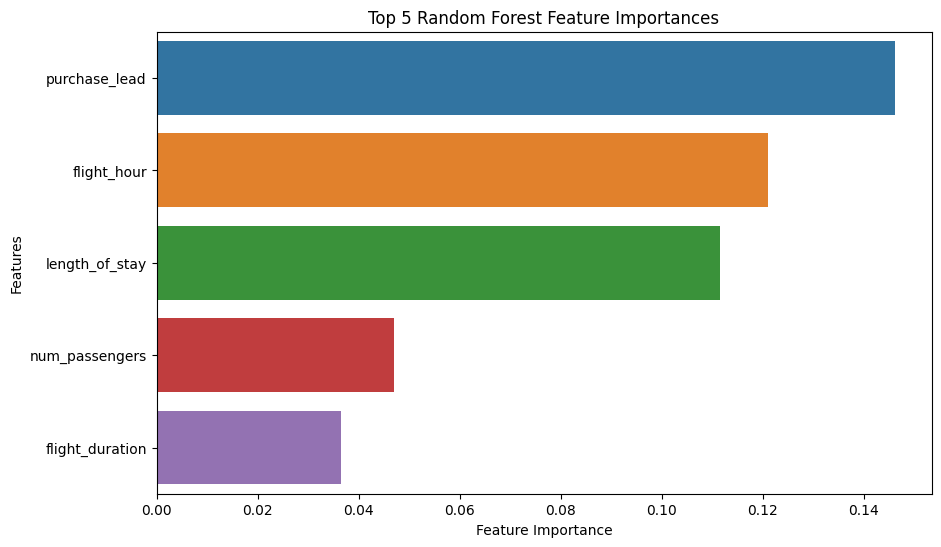

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame, and 'booking_complete' is the target variable
# Adjust the target variable if needed

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin'])

# Prepare features and target
X = df_encoded.drop('booking_complete', axis=1)
y = df_encoded['booking_complete']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

# Classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize feature importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Plotting the top 5 features
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.head(5), y=feature_importances.head(5).index)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 5 Random Forest Feature Importances')
plt.show()
